# Generative Models Lab

## Imports 

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import random

In [2]:
IMG_SIZE = 28
batch_size = 256
# latent_dims = 30
latent_dims = 500  # denoise AE

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Helpers 

In [4]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), IMG_SIZE, IMG_SIZE)
    return x

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

## Load Data 

In [5]:
dataset = MNIST('../data', transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Define AutoEncoder

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, img_size, latent_dimension):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(img_size * img_size, latent_dimension), # [batch_size, img_size * img_size (28*28)] -> [batch_size, latent_dimension (30)]
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dimension, img_size * img_size),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training of AutoEncoder

In [7]:
def train(denoise = False, num_epochs = 5, display_imgs = True):
    
    do = nn.Dropout() # Same as creating rnd tensor.
    noise = None
    for epoch in range(num_epochs):
        
        for data in dataloader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1) # Flatten [batch_size, 1, 28, 28] -> [batch_size, 1*28*28]
            
            # Check if the task is to denoise or not
            if denoise:
                noise = do(torch.ones(img.shape)).to(device)
                transformed_img = (img * noise).to(device)
            else:
                transformed_img = img
                
            output = model(transformed_img)
            loss = criterion(output, img.data)

            # Remember we need to zero_grad because the gradients accumulate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            
        print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
        
        # Print imgs if wanted
        if display_imgs:
            display_images(transformed_img, output)
            
    return [output, noise, transformed_img, img]

epoch [1/5], loss:0.0732
epoch [2/5], loss:0.0555
epoch [3/5], loss:0.0517
epoch [4/5], loss:0.0517
epoch [5/5], loss:0.0512


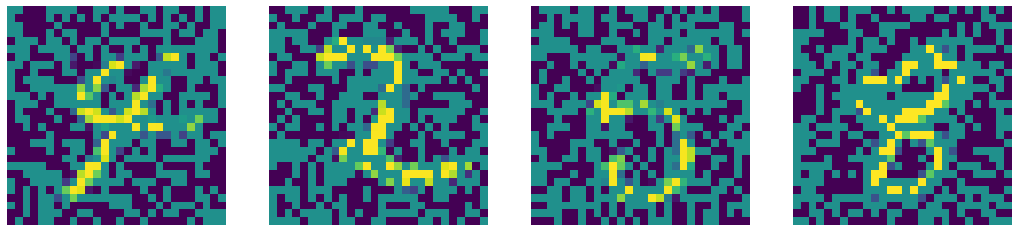

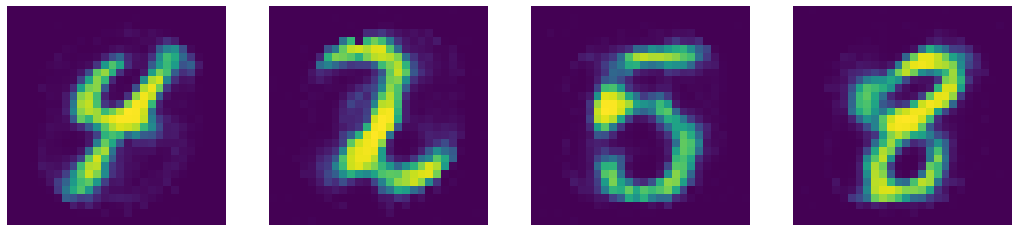

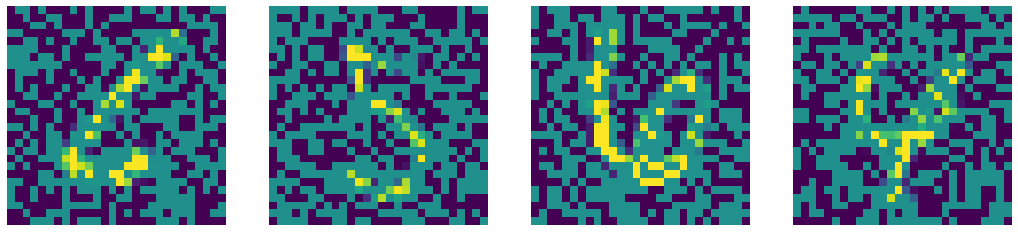

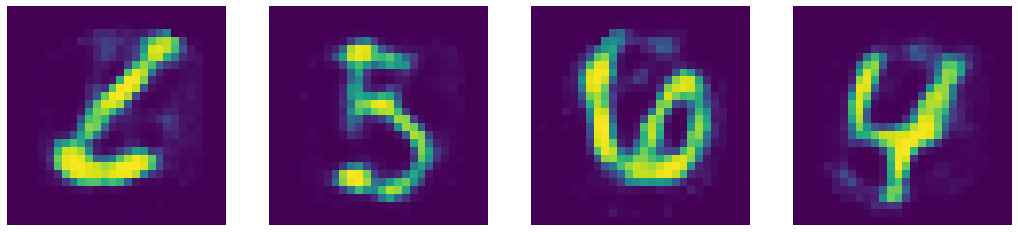

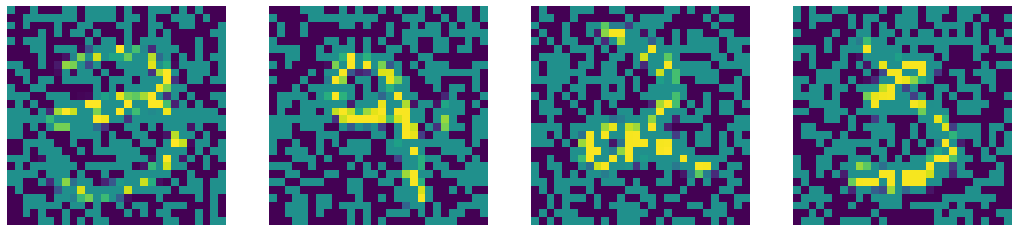

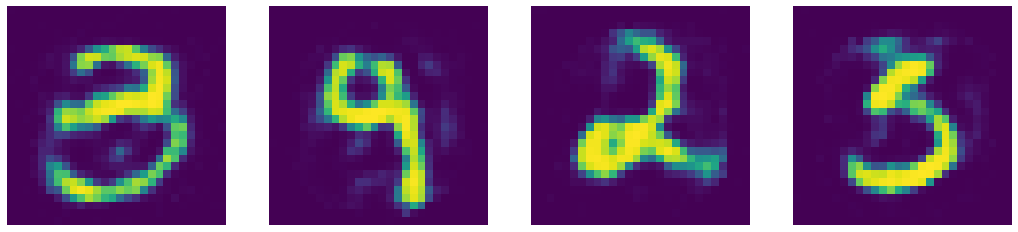

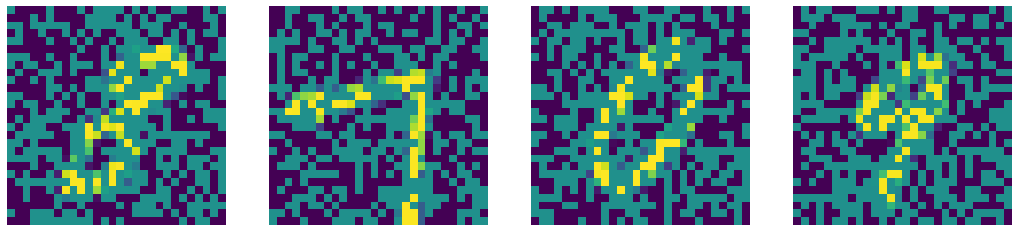

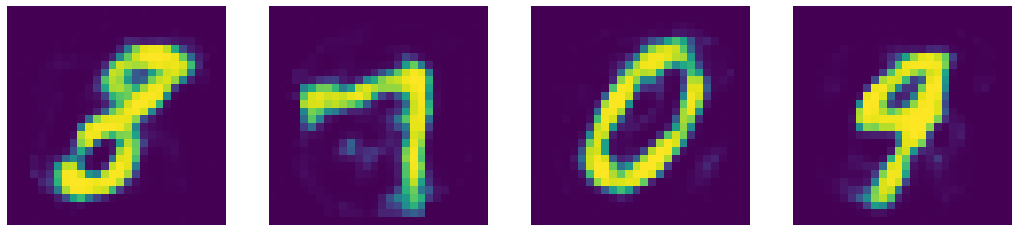

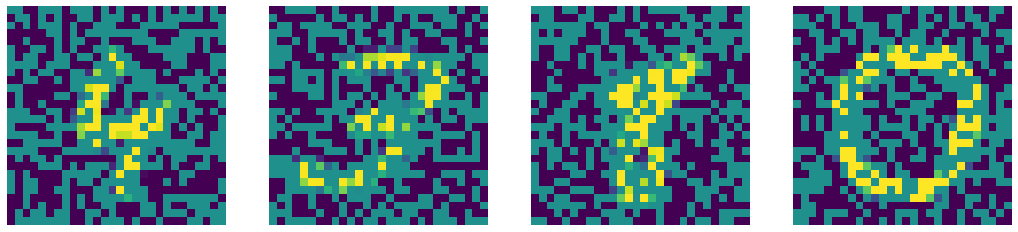

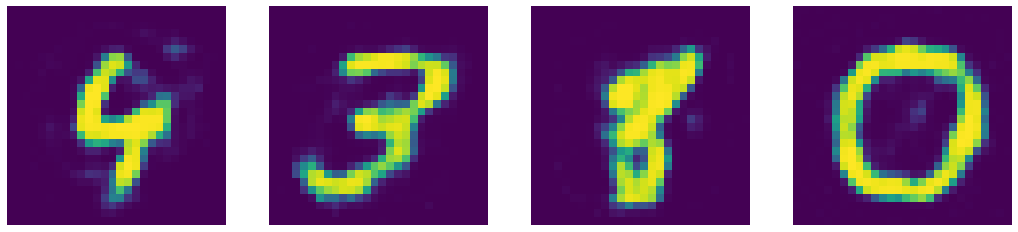

In [8]:
model = Autoencoder(IMG_SIZE, latent_dims).to(device)
criterion = nn.MSELoss()

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

train_output = train(denoise = True)

## Visualize the kernels 

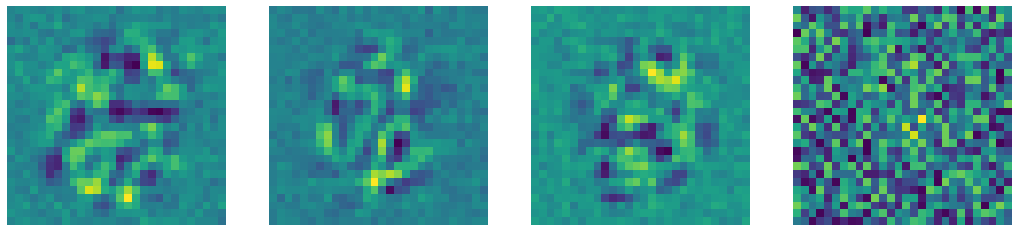

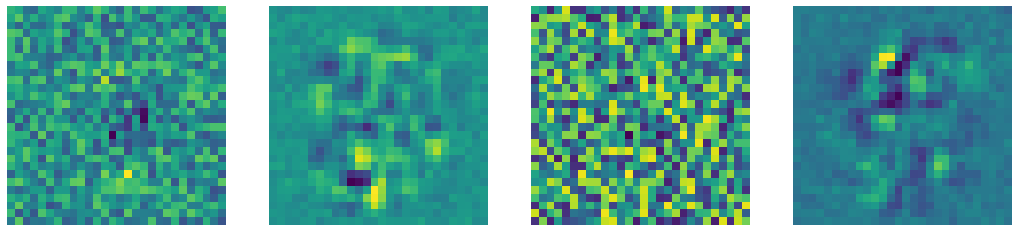

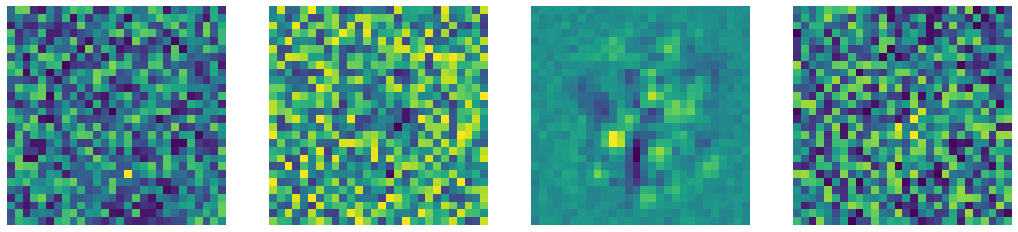

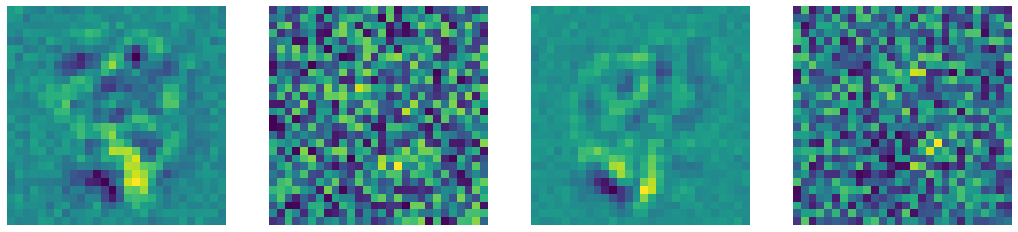

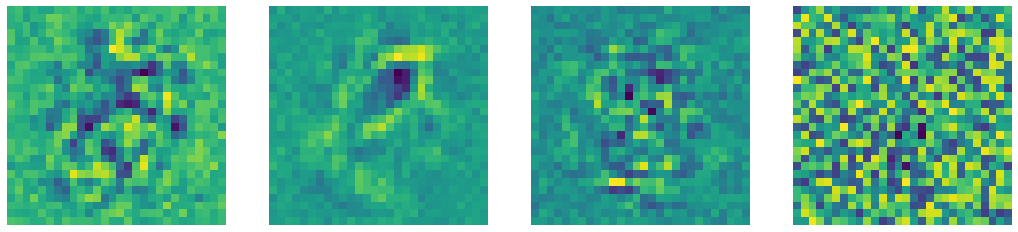

In [11]:
display_images(None, model.encoder[0].weight, 5)

## Comparing to CV2 inpainiting 

In [13]:
from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA

In [14]:
# Inpaint with Telea and Navier-Stokes methods

dst_TELEA = list()
dst_NS = list()

for i in range(3, 7):
    corrupted_img = ((train_output[2].data.cpu()[i].view(IMG_SIZE, IMG_SIZE) / 4 + 0.5) * 255).byte().numpy()
    mask = 2 - train_output[1].cpu()[i].view(IMG_SIZE, IMG_SIZE).byte().numpy()
    dst_TELEA.append(inpaint(corrupted_img, mask, 3, INPAINT_TELEA))
    dst_NS.append(inpaint(corrupted_img, mask, 3, INPAINT_NS))

tns_TELEA = [torch.from_numpy(d) for d in dst_TELEA]
tns_NS = [torch.from_numpy(d) for d in dst_NS]

TELEA = torch.stack(tns_TELEA).float()
NS = torch.stack(tns_NS).float()

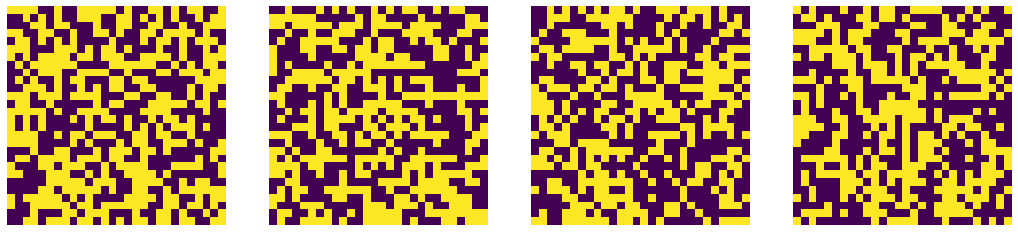

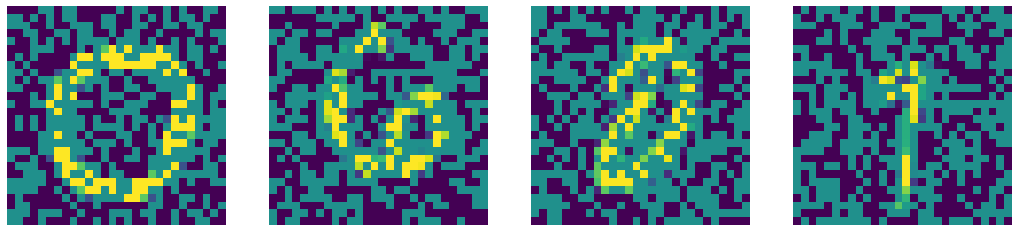

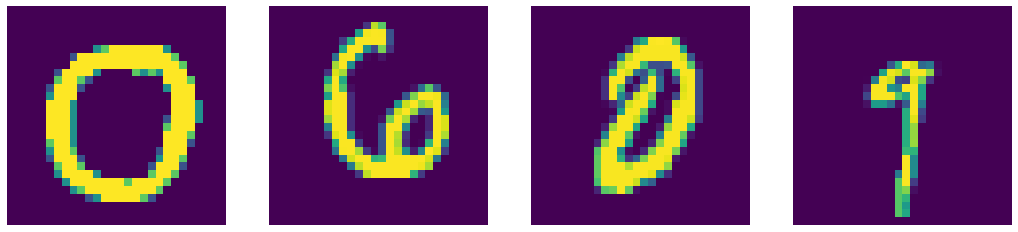

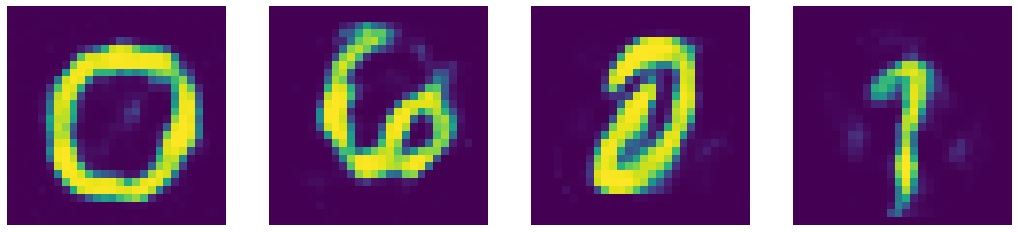

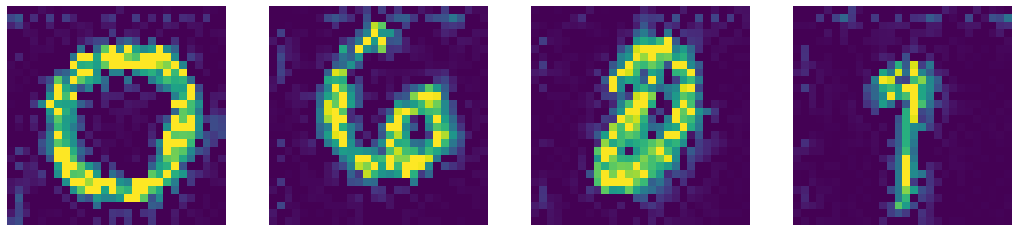

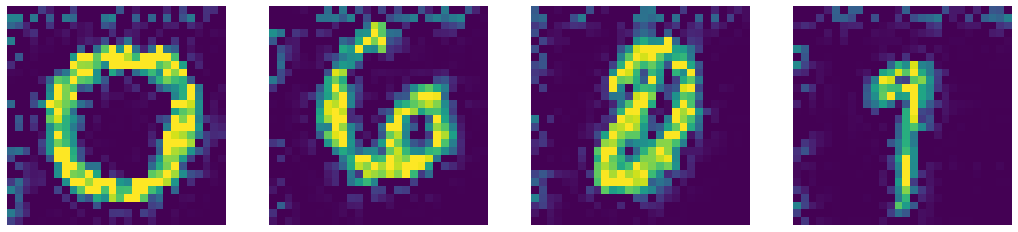

In [15]:
# Compare the results: [noise], [img + noise], [img], [AE, Telea, Navier-Stokes] inpainting

with torch.no_grad():
    display_images(train_output[1][3:7], train_output[2][3:7])
    display_images(train_output[3][3:7], train_output[0][3:7])
    display_images(TELEA, NS)